In [1]:
import tqdm
import math
import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from torchvision import transforms
from datasets import load_dataset
from accelerate import Accelerator
from diffusers.optimization import get_cosine_schedule_with_warmup
from diffusers.utils import make_image_grid

c:\Users\caspe\anaconda3\lib\site-packages\transformers\utils\generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
IMAGE_SIZE = 128
LR_WARMUP_STEPS = 250
BATCH_SIZE = 16
NUM_EPOCHS = 30
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
from diffusers import UNet2DModel
model = UNet2DModel(
    sample_size=IMAGE_SIZE,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

c:\Users\caspe\anaconda3\lib\site-packages\transformers\utils\generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [4]:
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-4)

dataset = load_dataset("huggan/selfie2anime", split="train")
preprocess = transforms.Compose([
    transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])
def transform(examples):
    images = [preprocess(image) for image in examples["imageB"]]
    return {"images":images}

In [5]:
model.to(device)

accelerator = Accelerator(
    mixed_precision="fp16",
)

dataset.set_transform(transform)
data_loader = torch.utils.data.DataLoader(dataset,batch_size=BATCH_SIZE,shuffle=True)

model,optimizer,train_dataloader = accelerator.prepare(model,optimizer,data_loader)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=LR_WARMUP_STEPS,
    num_training_steps=(len(train_dataloader)*NUM_EPOCHS)
)

In [6]:
def show_images(image_size,num_images=5):
    steps = 1000
    plot_every = 100
    images = []
    for _ in range(3):
        xt = torch.randn((1,3,image_size,image_size)).to(device)
        for i,t in enumerate(torch.linspace(0,1,steps), start=1):
            pred = model(xt,t.to(device)).sample
            xt = xt + (1/steps) * pred
        images.append(xt.squeeze(0).detach().cpu().permute(1, 2, 0))
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        ax.axis("off")  # Hide the axes
        ax.set_title(f"Image {i+1}")
    plt.tight_layout()
    plt.show()

Epoch 0:   0%|          | 0/213 [00:00<?, ?it/s]c:\Users\caspe\anaconda3\lib\site-packages\diffusers\models\attention_processor.py:3286: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  hidden_states = F.scaled_dot_product_attention(
Epoch 0: 100%|██████████| 213/213 [01:34<00:00,  4.10s/it, loss=0.201, lr=8.52e-5, step=212]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


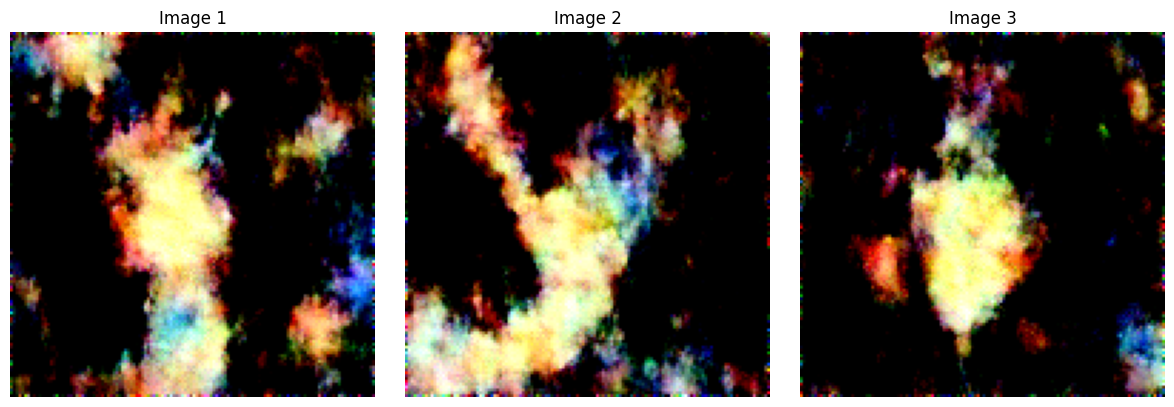

Epoch 2: 100%|██████████| 213/213 [06:20<00:00,  1.79s/it, loss=0.189, lr=9.9e-5, step=638] 
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


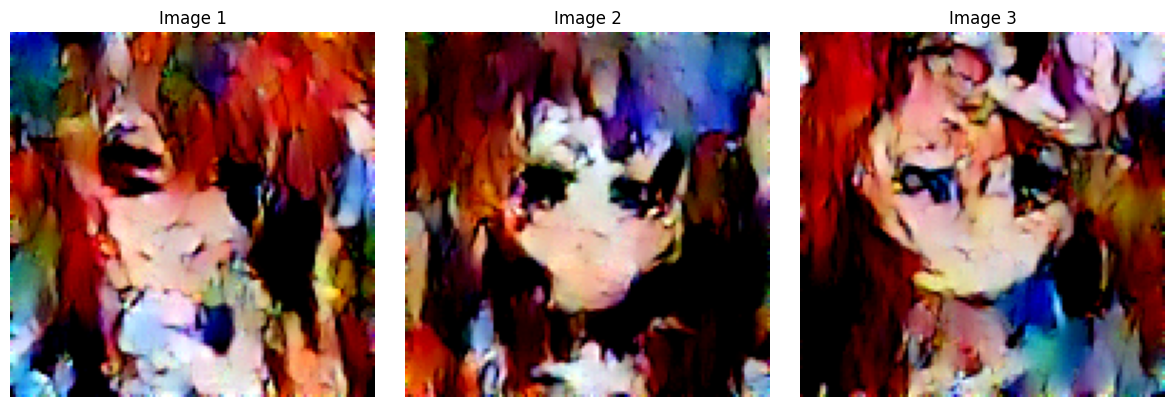

Epoch 6: 100%|██████████| 213/213 [06:22<00:00,  3.50s/it, loss=0.118, lr=9.03e-5, step=1490] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


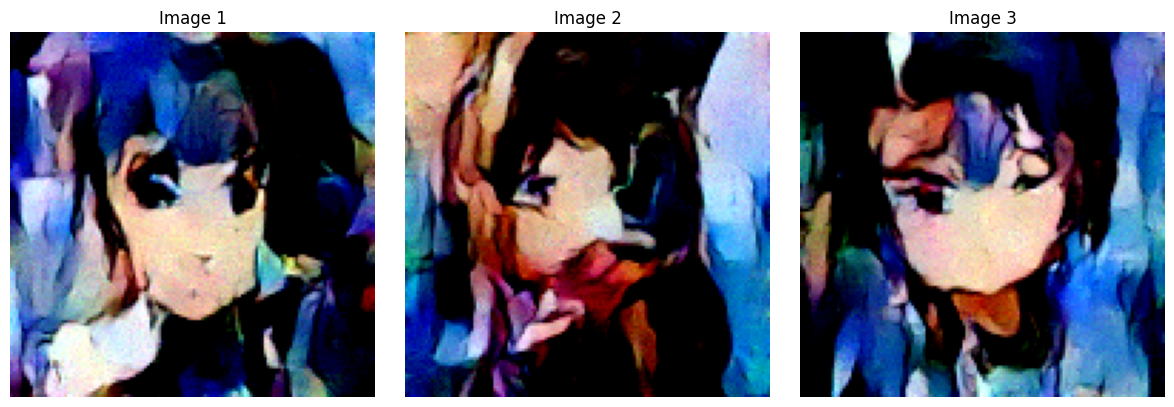

Epoch 8: 100%|██████████| 213/213 [04:15<00:00,  1.20s/it, loss=0.186, lr=8.29e-5, step=1916] 
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


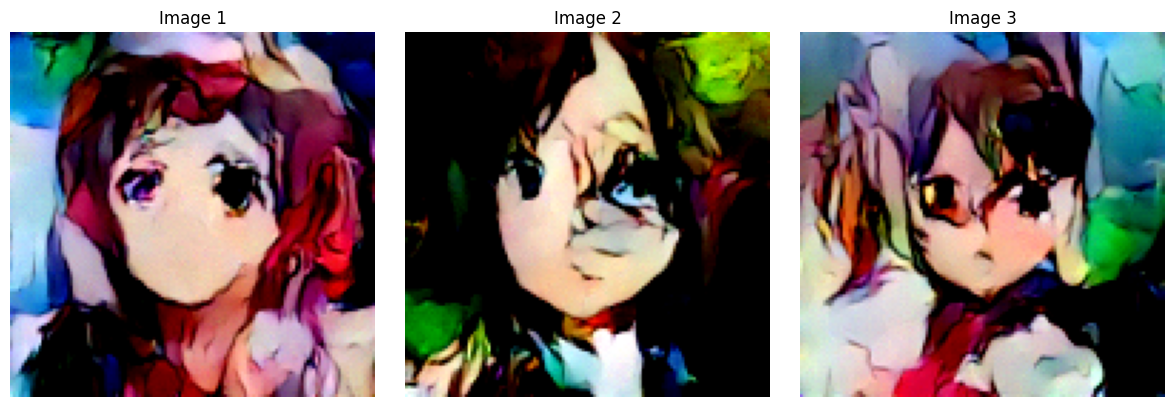

Epoch 12: 100%|██████████| 213/213 [02:03<00:00,  1.04s/it, loss=0.0884, lr=6.39e-5, step=2768]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


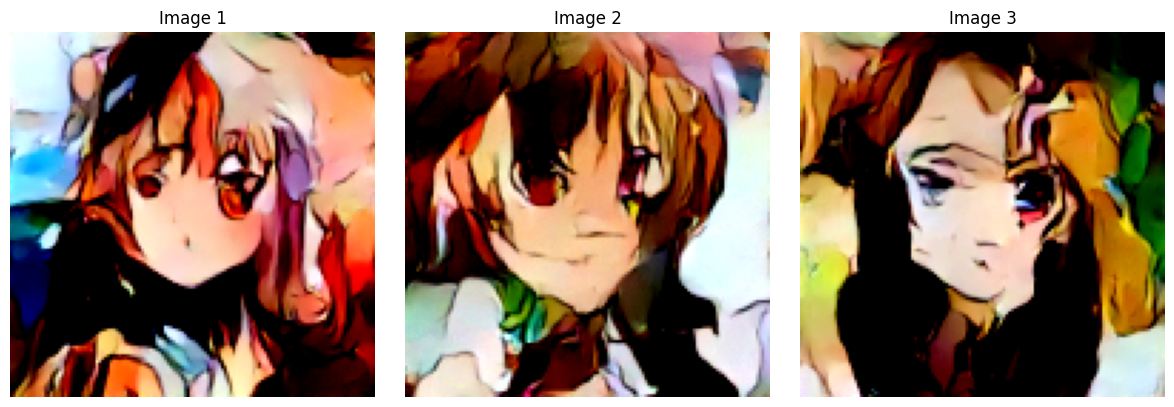

Epoch 14: 100%|██████████| 213/213 [02:02<00:00,  1.74it/s, loss=0.148, lr=5.32e-5, step=3194] 
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


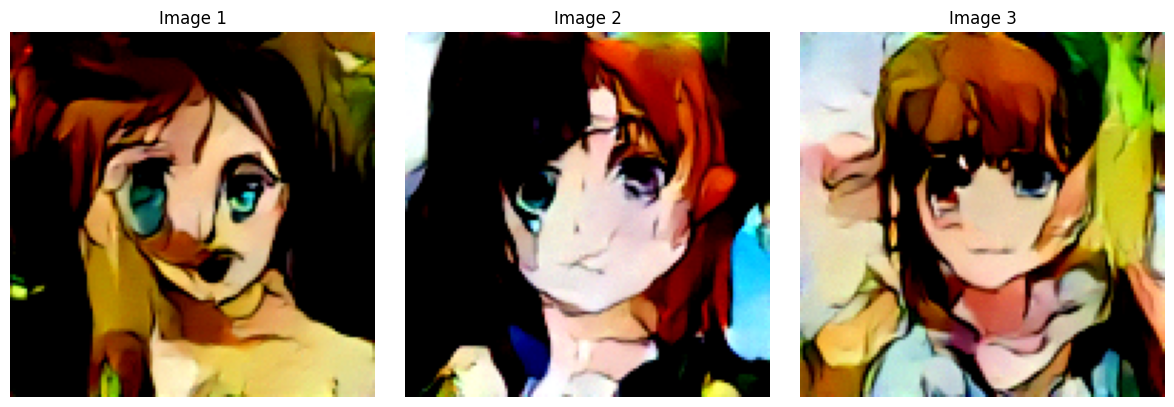

Epoch 18: 100%|██████████| 213/213 [02:04<00:00,  1.10s/it, loss=0.108, lr=3.18e-5, step=4046] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


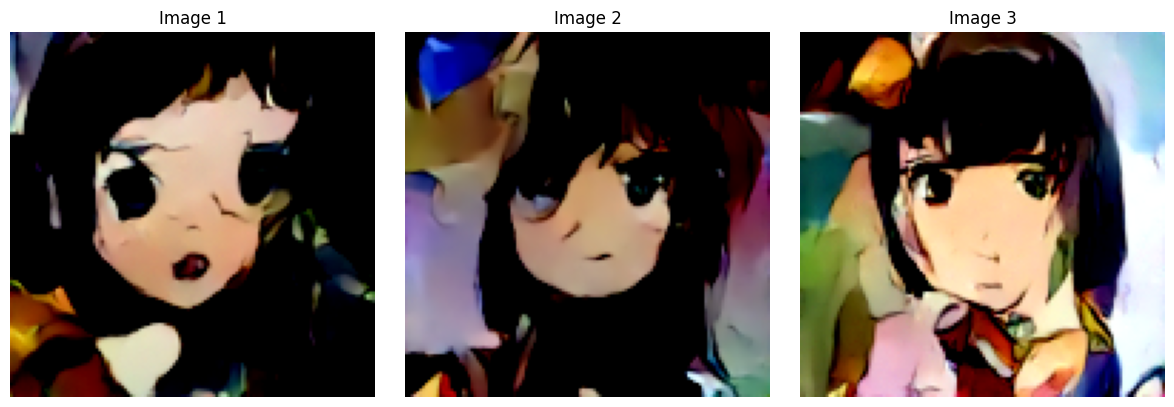

Epoch 20: 100%|██████████| 213/213 [02:02<00:00,  1.74it/s, loss=0.122, lr=2.22e-5, step=4472] 
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


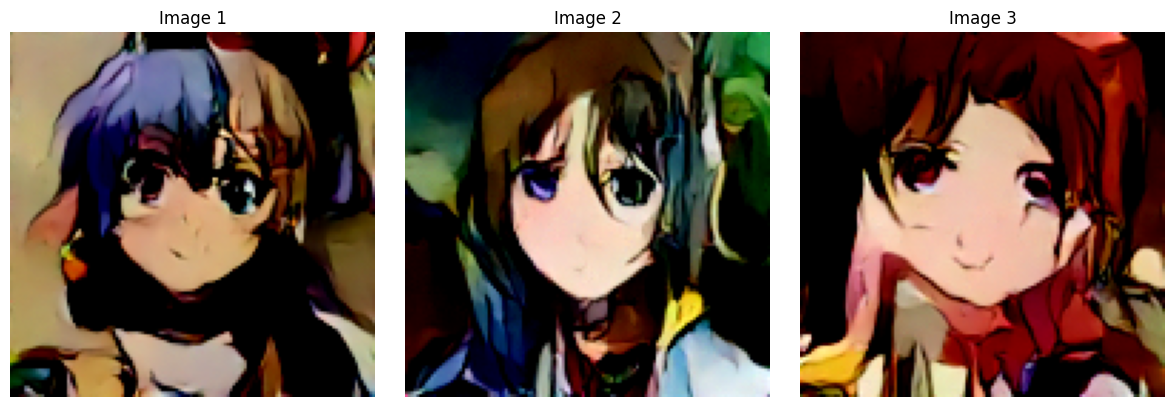

Epoch 24: 100%|██████████| 213/213 [02:10<00:00,  1.20s/it, loss=0.101, lr=7.24e-6, step=5324] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


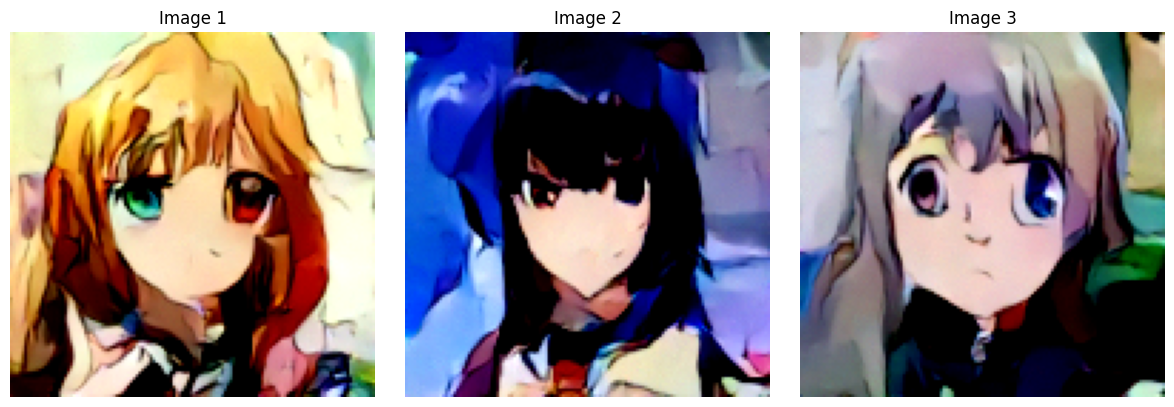

Epoch 26: 100%|██████████| 213/213 [01:41<00:00,  2.11it/s, loss=0.106, lr=2.65e-6, step=5750] 
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


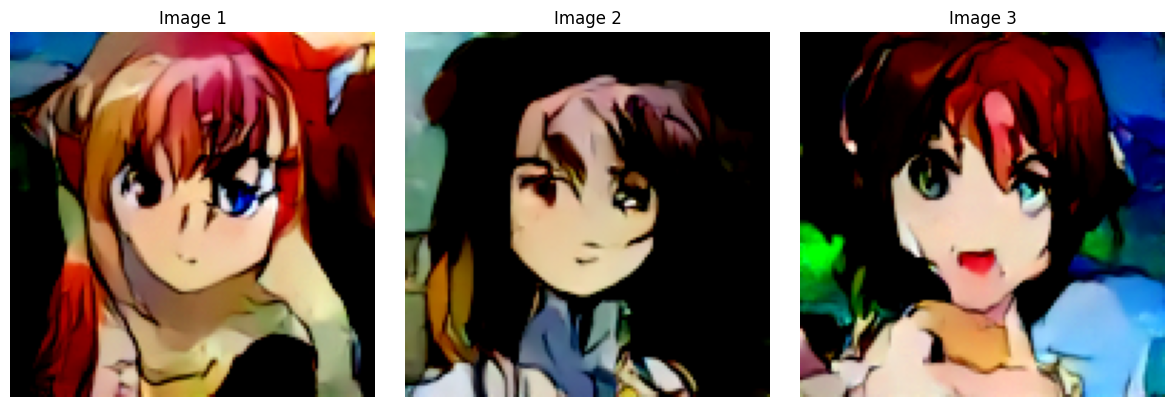

Epoch 28: 100%|██████████| 213/213 [01:45<00:00,  2.02it/s, loss=0.0751, lr=2.97e-7, step=6176]


In [7]:
global_step = 0
for epoch in range(NUM_EPOCHS):
    progress_bar = tqdm.tqdm(total=len(data_loader),disable=not accelerator.is_local_main_process)
    progress_bar.set_description(f"Epoch {epoch}")

    for step, batch in enumerate(train_dataloader):
        x1 = batch["images"].to(device)
        x0 = torch.randn_like(x1).to(device)
        t = torch.rand(x1.size(0),device=device)
        xt = (1 - t[:,None,None,None]) * x0 + t[:,None,None,None] * x1

        with accelerator.accumulate(model):
            pred = model(xt,t,return_dict=False)[0]
            target = x1 - x0
            loss = F.mse_loss(pred,target)
            accelerator.backward(loss)
            accelerator.clip_grad_norm_(model.parameters(),1.0)
            lr_scheduler.step()
            optimizer.step()
            optimizer.zero_grad()
        progress_bar.update(1)
        logs = {"loss": loss.detach().item(), "lr":lr_scheduler.get_last_lr()[0],"step":global_step}
        progress_bar.set_postfix(**logs)
        global_step += 1
    
    if epoch % 3 == 0:
        with torch.no_grad():
            show_images(IMAGE_SIZE)